In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import gc
import time
from pandas.core.common import SettingWithCopyWarning
import warnings
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from pandas.io.json import json_normalize
import json
import os
warnings.simplefilter('error', SettingWithCopyWarning)
gc.enable()
%matplotlib inline

In [2]:
features = ['channelGrouping', 'date', 'fullVisitorId', 'visitId',\
       'visitNumber', 'visitStartTime', 'device_browser',\
       'device_deviceCategory', 'device_isMobile', 'device_operatingSystem',\
       'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country',\
       'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region',\
       'geoNetwork_subContinent', 'totals_bounces', 'totals_hits',\
       'totals_newVisits', 'totals_pageviews', 'totals_transactionRevenue',\
       'trafficSource_adContent', 'trafficSource_campaign',\
       'trafficSource_isTrueDirect', 'trafficSource_keyword',\
       'trafficSource_medium', 'trafficSource_referralPath',\
       'trafficSource_source','trafficSource_adwordsClickInfo.page',\
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.isVideoAd',
       'trafficSource_adwordsClickInfo.slot',
           ]

In [ ]:
gc.enable()
def load_df(csv_path='/home/baitong/pywork/RevenuePrediction/all (1)/train_v2.csv'):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    ans = pd.DataFrame()
    dfs = pd.read_csv(csv_path, sep=',',
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                    chunksize = 100000)
    for df in dfs:
        df.reset_index(drop = True,inplace = True)
        for column in JSON_COLUMNS:
            column_as_df = json_normalize(df[column])
            column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
            df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

        print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
        use_df = df[features]
        del df
        gc.collect()
        ans = pd.concat([ans, use_df], axis = 0).reset_index(drop = True)
        print(ans.shape)
    return ans

train = load_df()
train.shape

In [3]:
path = '/home/baitong/pywork/RevenuePrediction/all (1)'
test = load_df("/home/baitong/pywork/RevenuePrediction/all (1)/test_v2.csv")

In [18]:
%%time
train = pd.read_csv(path+'/train.csv')
test = pd.read_csv(path+'/test.csv')


CPU times: user 7.29 s, sys: 397 ms, total: 7.69 s
Wall time: 7.69 s


In [21]:
#获取不变的常量列，模型无法在常量数据计学到东西，数据与处理时需要drop
const_cols = [c for c in train.columns if train[c].nunique(dropna=False)==1 ]
print(const_cols)


[]


In [22]:
train = train.drop(const_cols , axis=1)
test = test.drop(const_cols, axis=1)

In [23]:
train['depth']=train['trafficSource_referralPath'][train['trafficSource_referralPath'].notnull()].apply(lambda x:x.count('/'))
test['depth']=test['trafficSource_referralPath'][test['trafficSource_referralPath'].notnull()].apply(lambda x:x.count('/'))
# train['length']=train['trafficSource_referralPath'][train['trafficSource_referralPath'].notnull()].apply(lambda x:len(x))#例子里好像没有放在特征里
# train['path_complexity']=train['trafficSource_referralPath'][train['trafficSource_referralPath'].notnull()].apply(lambda x:train['depth']/train['length'])

In [24]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'visitId', 'visitNumber',
       'visitStartTime', 'device_browser', 'device_deviceCategory',
       'device_isMobile', 'device_operatingSystem', 'geoNetwork_city',
       'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro',
       'geoNetwork_networkDomain', 'geoNetwork_region',
       'geoNetwork_subContinent', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_pageviews', 'totals_transactionRevenue',
       'trafficSource_adContent', 'trafficSource_campaign',
       'trafficSource_isTrueDirect', 'trafficSource_keyword',
       'trafficSource_medium', 'trafficSource_referralPath',
       'trafficSource_source', 'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.isVideoAd',
       'trafficSource_adwordsClickInfo.slot', 'depth'],
      dtype='object')

In [25]:
##将缺失值表示统一
def replaceCatNa(df):
    Nalist = ['(not set)','0','not available in demo dataset','unknown.unknown','(not provided)','(none)']
    catlist = ['device_browser','device_operatingSystem','geoNetwork_city','geoNetwork_continent',
              'geoNetwork_metro','geoNetwork_networkDomain','geoNetwork_region','geoNetwork_subContinent',
              'trafficSource_campaign','trafficSource_keyword','trafficSource_medium']
    for col in catlist:
        df[col] = df[col].astype('str') 
        df[col] = df[col].apply(lambda x : np.nan if x in Nalist else x)
    return df

In [26]:
train = replaceCatNa(train)
test = replaceCatNa(test)

In [28]:
# 去除test中不存在的列
# train.drop('trafficSource_campaignCode',inplace = True,axis = 1)

In [29]:
train.shape,test.shape

((1708337, 34), (401589, 34))

In [30]:
###将时间戳转换为标准时间表示
train.visitStartTime = pd.to_datetime(train.visitStartTime, unit='s')
test.visitStartTime = pd.to_datetime(test.visitStartTime, unit='s')
train["date"] = train.visitStartTime
test["date"] = test.visitStartTime

In [31]:
for df in [train, test]:
    df['weekday'] = df['date'].dt.dayofweek.astype(object)
    df['time'] = df['date'].dt.second + df['date'].dt.minute*60 + df['date'].dt.hour*3600
    df['month'] = df['date'].dt.month   # it must not be included in features during learning!
    df['day'] = df['date'].dt.date       # it must not be included in features during learning!
    df['hours'] = df['date'].dt.hour

In [32]:
####5，6为双休日
# train['hours'].value_counts()

In [33]:
###增加特征 ：是否为双休日
train['isWeekend'] = train['weekday'].apply(lambda x:1 if x>=5 else 0)
test['isWeekend'] = test['weekday'].apply(lambda x:1 if x>=5 else 0)

In [34]:
###填补totals.pageviews值
predmis = train[train['totals_pageviews'].isnull()]['totals_hits'].values
train.loc[(train['totals_pageviews'].isnull()),'totals_pageviews' ] = predmis

predmis = test[test['totals_pageviews'].isnull()]['totals_hits'].values
test.loc[(test['totals_pageviews'].isnull()),'totals_pageviews' ] = predmis

In [35]:
####增加特征：浏览器是否为Chrome
train['isChrome'] = train['device_browser'].apply(lambda x:1 if x=='Chrome' else 0)
test['isChrome'] = test['device_browser'].apply(lambda x:1 if x=='Chrome' else 0)

In [36]:
####增加特征：source是否为youtube ,mail.googleplex.com youtube.com
train['trafficSource_source'].astype('str',inplace = True)
test['trafficSource_source'].astype('str',inplace = True)
train['s_ismall'] = train['trafficSource_source'].apply(lambda x:1 if x=='mall.googleplex.com' else 0)
test['s_ismall'] = test['trafficSource_source'].apply(lambda x:1 if x=='mall.googleplex.com' else 0)

train['s_isyoutube'] = train['trafficSource_source'].apply(lambda x:1 if x=='youtube.com' else 0)
test['s_isyoutube'] = test['trafficSource_source'].apply(lambda x:1 if x=='youtube.com' else 0)

In [37]:
##增加特征：是否为desktop
train['d_isdesktop'] = train['device_deviceCategory'].apply(lambda x:1 if x=='desktop' else 0)
test['d_isdesktop'] = test['device_deviceCategory'].apply(lambda x:1 if x=='desktop' else 0)

train['d_Macintosh'] = train['device_operatingSystem'].apply(lambda x:1 if x=='Macintosh' else 0)
test['d_Macintosh'] = test['device_operatingSystem'].apply(lambda x:1 if x=='Macintosh' else 0)

train['d_Macintosh'] = train['device_operatingSystem'].apply(lambda x:1 if x=='Macintosh' else 0)
test['d_Macintosh'] = test['device_operatingSystem'].apply(lambda x:1 if x=='Macintosh' else 0)

train['d_Linux'] = train['device_operatingSystem'].apply(lambda x:1 if x=='Linux' else 0)
test['d_Linux'] = test['device_operatingSystem'].apply(lambda x:1 if x=='Linux' else 0)

train['d_iOS'] = train['device_operatingSystem'].apply(lambda x:1 if x=='iOS' else 0)
test['d_iOS'] = test['device_operatingSystem'].apply(lambda x:1 if x=='iOS' else 0)

train['d_Android'] = train['device_operatingSystem'].apply(lambda x:1 if x=='Android' else 0)
test['d_Android'] = test['device_operatingSystem'].apply(lambda x:1 if x=='Android' else 0)

train['d_Windows Phone'] = train['device_operatingSystem'].apply(lambda x:1 if x=='Windows Phone' else 0)
test['d_Windows Phone'] = test['device_operatingSystem'].apply(lambda x:1 if x=='Windows Phone' else 0)


In [38]:
train['channel_referral'] = train['channelGrouping'].apply(lambda x:1 if x=='Referral' else 0)
train['channel_Social'] = train['channelGrouping'].apply(lambda x:1 if x=='Social' else 0)
test['channel_referral'] = test['channelGrouping'].apply(lambda x:1 if x=='Referral' else 0)
test['channel_Social'] = test['channelGrouping'].apply(lambda x:1 if x=='Social' else 0)

In [39]:
def dealbrowser(s):
    if s == "Safari "or s == "Firefox":
        return "mainstream"
    elif s == "Chrome":
        return "Chrome"
    else:
        return "others"
train['browser'] = train['device_browser'].apply(dealbrowser)

In [40]:
##增加特征：是否为desktop
train['m_referral'] = train['trafficSource_medium'].apply(lambda x:1 if x=='referral' else 0)
test['m_referral'] = test['trafficSource_medium'].apply(lambda x:1 if x=='referral' else 0)

In [41]:
train['single_visit'] = train['visitNumber'].apply(lambda x:0 if x!=1 else 1)
test['single_visit'] = test['visitNumber'].apply(lambda x:0 if x!=1 else 1)

train['totals_hits'] = train['totals_hits'].astype('float') 
test['totals_hits'] = test['totals_hits'].astype('float') 
train['totals_pageviews'] = train['totals_pageviews'].astype('float') 
test['totals_pageviews'] = test['totals_pageviews'].astype('float') 
train['hits_ratio'] = train['totals_hits']/train['totals_pageviews']
test['hits_ratio'] = test['totals_hits']/test['totals_pageviews']

# tr_te[, single_visit := ifelse(visitNumber == 1,1,0) ]
#     tr_te[, hits_ratio := as.numeric(hits)/as.numeric(pageviews)]
#     tr_te[, domain_site := gsub("^.*\\.","", networkDomain)]
#     tr_te[, adwordsClickInfo.isVideoAd := ifelse(is.na(adwordsClickInfo.isVideoAd), 1, 0)]


In [42]:
##去除离群点'Anguilla'
train =train.drop(index = train['geoNetwork_country'][train['geoNetwork_country']=='Anguilla'].index)

In [43]:
def dealMissingData(df):
    for c in df.columns:
        num_missing = df[c].isnull().sum() 
        if num_missing != 0:
            print("missing col is  ",c,'   missing num is',num_missing)
    print('*'*20)
    num_feature = ["totals_bounces","totals_newVisits",'depth','trafficSource_adwordsClickInfo.page']
    cat_feature = ['trafficSource_adContent','trafficSource_adContent',
                  'trafficSource_campaign','trafficSource_isTrueDirect',
                  'trafficSource_keyword','trafficSource_referralPath',
                  'device_browser','device_operatingSystem','geoNetwork_city',
                  'geoNetwork_continent','geoNetwork_metro','geoNetwork_networkDomain',
                  'geoNetwork_region','geoNetwork_subContinent','trafficSource_adwordsClickInfo.adNetworkType',
                  'trafficSource_adwordsClickInfo.isVideoAd','trafficSource_medium','trafficSource_adwordsClickInfo.slot']
    for col in num_feature:
        df[col].fillna(0,inplace=True)
    for col in cat_feature:
        df[col].fillna(0,inplace=True)
    for c in df.columns:
        num_missing = df[c].isnull().sum() 
        if num_missing != 0:
            print("now missing col is  ",c,'   missing num is',num_missing)
    print('---------------done---------------')
    return df

In [44]:
train = dealMissingData(train)
test = dealMissingData(test)

missing col is   device_browser    missing num is 19
missing col is   device_operatingSystem    missing num is 11815
missing col is   geoNetwork_city    missing num is 998825
missing col is   geoNetwork_continent    missing num is 2517
missing col is   geoNetwork_metro    missing num is 1319854
missing col is   geoNetwork_networkDomain    missing num is 768844
missing col is   geoNetwork_region    missing num is 982732
missing col is   geoNetwork_subContinent    missing num is 2517
missing col is   totals_bounces    missing num is 836758
missing col is   totals_newVisits    missing num is 400907
missing col is   totals_transactionRevenue    missing num is 1689823
missing col is   trafficSource_adContent    missing num is 1643599
missing col is   trafficSource_campaign    missing num is 1604525
missing col is   trafficSource_isTrueDirect    missing num is 1173818
missing col is   trafficSource_keyword    missing num is 568933
missing col is   trafficSource_medium    missing num is 56609

In [45]:
def clearRare(columnname, limit = 1000):
    # you may search for rare categories in train, train&test, or just test
    #vc = pd.concat([train[columnname], test[columnname]], sort=False).value_counts()
    vc = test[columnname].value_counts()
    
    common = vc > limit
    common = set(common.index[common].values)
    print("Set", sum(vc <= limit), columnname, "categories to 'other';", end=" ")
    
    train.loc[train[columnname].map(lambda x: x not in common), columnname] = 'other'
    test.loc[test[columnname].map(lambda x: x not in common), columnname] = 'other'
    print("now there are", train[columnname].nunique(), "categories in train")

In [46]:
###数量过少的数据无参考价值，统一归为others
clearRare("device_browser")
clearRare("device_operatingSystem")
clearRare("geoNetwork_country")
clearRare("geoNetwork_city")
clearRare("geoNetwork_metro")
clearRare("geoNetwork_networkDomain")
clearRare("geoNetwork_region")
clearRare("geoNetwork_subContinent")
clearRare("trafficSource_adContent")
clearRare("trafficSource_campaign")
clearRare("trafficSource_keyword")
clearRare("trafficSource_medium")
clearRare("trafficSource_referralPath")
clearRare("trafficSource_source")

Set 52 device_browser categories to 'other'; now there are 11 categories in train
Set 15 device_operatingSystem categories to 'other'; now there are 8 categories in train
Set 162 geoNetwork_country categories to 'other'; now there are 47 categories in train
Set 461 geoNetwork_city categories to 'other'; now there are 42 categories in train
Set 67 geoNetwork_metro categories to 'other'; now there are 15 categories in train
Set 15910 geoNetwork_networkDomain categories to 'other'; now there are 24 categories in train
Set 235 geoNetwork_region categories to 'other'; now there are 34 categories in train
Set 8 geoNetwork_subContinent categories to 'other'; now there are 16 categories in train
Set 25 trafficSource_adContent categories to 'other'; now there are 2 categories in train
Set 19 trafficSource_campaign categories to 'other'; now there are 4 categories in train
Set 672 trafficSource_keyword categories to 'other'; now there are 6 categories in train
Set 0 trafficSource_medium categori

In [47]:
train.set_index("visitStartTime", inplace=True)
test.set_index("visitStartTime", inplace=True)
train.sort_index(inplace=True)
test.sort_index(inplace=True)

In [48]:
###增加上一次会话和下一次会话的时间间隔，时间间隔越短说明用户购买商品欲望更强烈
df = pd.concat([train, test])
df.sort_values(['fullVisitorId', 'date'], ascending=True, inplace=True)
df['prev_session'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(1)).astype(np.int64) // 1e9 // 60 // 60
df['next_session'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(-1)).astype(np.int64) // 1e9 // 60 // 60
df.sort_index(inplace=True)

train = df[:len(train)]
test = df[len(train):]

/home/baitong/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [49]:
##将缺失的0 转换为字符串格式
str_feature = ['trafficSource_adContent','trafficSource_campaign','trafficSource_isTrueDirect',
              'trafficSource_keyword','trafficSource_referralPath',
              'device_browser','device_operatingSystem','geoNetwork_city',
              'geoNetwork_continent','geoNetwork_metro','geoNetwork_networkDomain',
              'geoNetwork_region','geoNetwork_subContinent','trafficSource_adwordsClickInfo.adNetworkType',
              'trafficSource_adwordsClickInfo.isVideoAd','trafficSource_medium','trafficSource_adwordsClickInfo.slot']
for df in [train, test]:
    for col in str_feature:
        df[col] = df[col].astype('str')

In [50]:
##组合特征
for df in [train, test]:
    df['source_country'] = df['trafficSource_source'] + '_' + df['geoNetwork_country']
    df['campaign_medium'] = df['trafficSource_campaign'] + '_' + df['trafficSource_medium']
    df['browser_category'] = df['device_browser'] + '_' + df['device_deviceCategory']
    df['browser_os'] = df['device_browser'] + '_' + df['device_operatingSystem']

In [51]:
##组合特征
for df in [train, test]:
    df['device_deviceCategory_channelGrouping'] = df['device_deviceCategory'] + "_" + df['channelGrouping']
    df['channelGrouping_browser'] = df['device_browser'] + "_" + df['channelGrouping']
    df['channelGrouping_OS'] = df['device_operatingSystem'] + "_" + df['channelGrouping']
    
    for i in ['geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country','geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region','geoNetwork_subContinent']:
        for j in ['device_browser','device_deviceCategory', 'device_operatingSystem', 'trafficSource_source']:
            df[i + "_" + j] = df[i] + "_" + df[j]
    
    df['content_source'] = df['trafficSource_adContent'].astype(str) + "_" + df['source_country']
    df['medium_source'] = df['trafficSource_medium'] + "_" + df['source_country']

In [52]:
##针对用户增加点击浏览量均值特征，以及访问人数最大值特征
for feature in ["totals_hits", "totals_pageviews"]:
    info = pd.concat([train, test], sort=False).groupby("fullVisitorId")[feature].mean()
    train["usermean_" + feature] = train.fullVisitorId.map(info)
    test["usermean_" + feature] = test.fullVisitorId.map(info)
    
for feature in ["visitNumber"]:
    info = pd.concat([train, test], sort=False).groupby("fullVisitorId")[feature].max()
    train["usermax_" + feature] = train.fullVisitorId.map(info)
    test["usermax_" + feature] = test.fullVisitorId.map(info)

In [53]:
excluded = ['date', 'fullVisitorId', 'sessionId', 'totals_transactionRevenue', 'visitId', 'visitStartTime', 
            'month', 'day','trafficSource_adwordsClickInfo.gclId']

cat_cols = [f for f in train.columns if (train[f].dtype == 'object' and f not in excluded)]
real_cols = [f for f in train.columns if (not f in cat_cols and f not in excluded)]
print("cat_cols num: ",len(cat_cols))
print("cat_cols: ",cat_cols)
print("real_cols num: ",len(real_cols))
print("real_cols: ",real_cols)

cat_cols num:  60
cat_cols:  ['browser', 'channelGrouping', 'device_browser', 'device_deviceCategory', 'device_operatingSystem', 'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region', 'geoNetwork_subContinent', 'trafficSource_adContent', 'trafficSource_adwordsClickInfo.adNetworkType', 'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign', 'trafficSource_isTrueDirect', 'trafficSource_keyword', 'trafficSource_medium', 'trafficSource_referralPath', 'trafficSource_source', 'weekday', 'source_country', 'campaign_medium', 'browser_category', 'browser_os', 'device_deviceCategory_channelGrouping', 'channelGrouping_browser', 'channelGrouping_OS', 'geoNetwork_city_device_browser', 'geoNetwork_city_device_deviceCategory', 'geoNetwork_city_device_operatingSystem', 'geoNetwork_city_trafficSource_source', 'geoNetwork_continent_device_browser', 'geoNetwork_continent_dev

In [54]:
y_reg = train['totals_transactionRevenue']

In [55]:
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    lbl = LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

In [56]:
for col in real_cols:
    train[col] = train[col].astype(float)
    test[col] = test[col].astype(float)

In [57]:
train['r_status'] = train['totals_transactionRevenue'].fillna(0).astype("float").apply(lambda x : 1 if x>0 else 0)

In [58]:
def get_folds(df=None, n_splits=5):
    """Returns dataframe indices corresponding to Visitors Group KFold"""
    # Get sorted unique visitors
    unique_vis = np.array(sorted(df['fullVisitorId'].unique()))

    # Get folds
    folds = GroupKFold(n_splits=n_splits)
    fold_ids = []
    ids = np.arange(df.shape[0])
    for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
        fold_ids.append(
            [
                ids[df['fullVisitorId'].isin(unique_vis[trn_vis])],
                ids[df['fullVisitorId'].isin(unique_vis[val_vis])]
            ]
        )

    return fold_ids

In [59]:
train_features = real_cols + cat_cols
y_clf=train["r_status"].astype("float")

In [60]:
y_clf.value_counts()

0.0    1689823
1.0      18513
Name: r_status, dtype: int64

In [61]:
# from xgboost import XGBClassifier
import xgboost as xgb
xgb_params = {
#         'objective': "binary:logistic",
        'objective':'binary:logistic',
        'eval_metric': 'auc',
        'booster': 'gbtree',
        'learning_rate': 0.2,
        'max_depth': 8,
        'min_child_weight': 30,
        'eta':0.2/100,
        'gamma' : 0,
        'alpha': 0.0,
        'lambda': 0.0,
        'subsample': 0.5,
        'colsample_bytree': 0.5,
        'colsample_bylevel': 0.632,
        'n_jobs': -1,
        'random_state': 456,
#         'nroubds' : 100
    }
folds = get_folds(df=train, n_splits=5)
xgb_oof_preds = np.zeros(train.shape[0],dtype = "float")
xgb_sub_preds = np.zeros(test.shape[0],dtype = "float")
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train[train_features].iloc[trn_], y_clf.iloc[trn_]
    val_x, val_y = train[train_features].iloc[val_], y_clf.iloc[val_]
    
    
    dtrain=xgb.DMatrix(trn_x,label=trn_y)
    dval=xgb.DMatrix(val_x,label=val_y)
    
    evallist = [(dval, 'eval'), (dtrain, 'train')]
    bst=xgb.train(xgb_params,dtrain,num_boost_round=100,evals = evallist,early_stopping_rounds=10)
#     bst = XGBClassifier(**xgb_params, n_estimators=100,objective='binary:logistic')
    
#     bst.fit(trn_x, trn_y,
#             eval_set=[(val_x, val_y)],
#             early_stopping_rounds=10,
#             eval_metric='auc',
#             verbose=10
#             )
    
    xgb_oof_preds[val_] = bst.predict(dval)
    xgb_oof_preds[val_][:100]
    xgb_oof_preds[xgb_oof_preds < 0] = 0
    
    # Make sure features are in the same order
    dtest = xgb.DMatrix(test[train_features])
    _preds = bst.predict(dtest)
    _preds[_preds < 0] = 0
    xgb_sub_preds += _preds / len(folds)
    
mean_squared_error(y_clf, xgb_oof_preds) ** .5

[14:50:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=8
[0]	eval-auc:0.977881	train-auc:0.982834
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 10 rounds.
[14:50:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=8
[1]	eval-auc:0.983322	train-auc:0.985484
[14:50:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=8
[2]	eval-auc:0.98266	train-auc:0.984447
[14:50:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=8
[3]	eval-auc:0.982468	train-auc:0.984206
[14:50:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=8
[4]	eval-auc:0.984538	train-auc:0.986221
[14:50:56] /workspace/src/tree/up

[14:51:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[49]	eval-auc:0.988918	train-auc:0.990479
[14:51:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[50]	eval-auc:0.988914	train-auc:0.990493
[14:51:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=8
[51]	eval-auc:0.988925	train-auc:0.990531
[14:51:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[52]	eval-auc:0.988915	train-auc:0.990555
[14:51:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=8
[53]	eval-auc:0.988945	train-auc:0.990591
[14:51:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[54]	eval-auc:0.988976	train-auc:0.990624
[14:51:3

[14:52:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[99]	eval-auc:0.989168	train-auc:0.991541
[14:52:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=8
[0]	eval-auc:0.976319	train-auc:0.981819
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 10 rounds.
[14:52:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=8
[1]	eval-auc:0.982511	train-auc:0.98663
[14:52:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=8
[2]	eval-auc:0.984257	train-auc:0.986581
[14:52:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=8
[3]	eval-auc:0.985287	train-auc:0.987282
[14:52:28] /workspace/src/tree/up

[14:53:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[48]	eval-auc:0.988912	train-auc:0.990459
[14:53:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[49]	eval-auc:0.98892	train-auc:0.990481
[14:53:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=8
[50]	eval-auc:0.988938	train-auc:0.990523
[14:53:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[51]	eval-auc:0.988962	train-auc:0.990557
[14:53:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[52]	eval-auc:0.988964	train-auc:0.990583
[14:53:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=8
[53]	eval-auc:0.988954	train-auc:0.990612
[14:53:10

[14:53:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[98]	eval-auc:0.98905	train-auc:0.99148
[14:53:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[99]	eval-auc:0.989059	train-auc:0.991501
[14:53:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=8
[0]	eval-auc:0.977657	train-auc:0.981938
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 10 rounds.
[14:53:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=8
[1]	eval-auc:0.983454	train-auc:0.98656
[14:53:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=8
[2]	eval-auc:0.984583	train-auc:0.987266
[14:53:58] /workspace/src/tree/upda

[14:54:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[47]	eval-auc:0.988342	train-auc:0.990469
[14:54:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[48]	eval-auc:0.988335	train-auc:0.990493
[14:54:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[49]	eval-auc:0.988356	train-auc:0.990515
[14:54:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[50]	eval-auc:0.988365	train-auc:0.990527
[14:54:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=8
[51]	eval-auc:0.988371	train-auc:0.990553
[14:54:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=8
[52]	eval-auc:0.988409	train-auc:0.990601
[14:54:41

[14:55:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[97]	eval-auc:0.98855	train-auc:0.991596
[14:55:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[98]	eval-auc:0.988546	train-auc:0.991609
[14:55:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[99]	eval-auc:0.988545	train-auc:0.991622
[14:55:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=8
[0]	eval-auc:0.981713	train-auc:0.984252
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 10 rounds.
[14:55:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=8
[1]	eval-auc:0.984315	train-auc:0.986918
[14:55:29] /workspace/src/tree/up

[14:56:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[46]	eval-auc:0.989365	train-auc:0.990142
[14:56:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[47]	eval-auc:0.989375	train-auc:0.990173
[14:56:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[48]	eval-auc:0.989381	train-auc:0.990178
[14:56:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[49]	eval-auc:0.989395	train-auc:0.990204
[14:56:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=8
[50]	eval-auc:0.989397	train-auc:0.990236
[14:56:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[51]	eval-auc:0.98942	train-auc:0.990273
[14:56:11]

[14:56:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[96]	eval-auc:0.98966	train-auc:0.991356
[14:56:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[97]	eval-auc:0.989659	train-auc:0.991372
[14:56:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[98]	eval-auc:0.989643	train-auc:0.99138
[14:56:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[99]	eval-auc:0.989645	train-auc:0.991397
[14:56:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=8
[0]	eval-auc:0.979325	train-auc:0.982339
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 10 rounds.
[14:56:58] /workspace/src/tree/upd

[14:57:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[45]	eval-auc:0.989489	train-auc:0.990182
[14:57:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[46]	eval-auc:0.989508	train-auc:0.990205
[14:57:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[47]	eval-auc:0.989521	train-auc:0.990225
[14:57:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[48]	eval-auc:0.989537	train-auc:0.99025
[14:57:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[49]	eval-auc:0.989538	train-auc:0.990267
[14:57:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[50]	eval-auc:0.989546	train-auc:0.990284
[14:57:41] 

[14:58:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[95]	eval-auc:0.989736	train-auc:0.991442
[14:58:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=8
[96]	eval-auc:0.989733	train-auc:0.991465
[14:58:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[97]	eval-auc:0.989728	train-auc:0.99148
[14:58:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[98]	eval-auc:0.989734	train-auc:0.991486
[14:58:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=8
[99]	eval-auc:0.989733	train-auc:0.991506


0.08395713739573896

In [62]:
# xgb_oof_preds

In [63]:
train_pred_r_status = pd.DataFrame()
test_pred_r_status = pd.DataFrame()
train['pred_r_status']=xgb_oof_preds
test['pred_r_status']=xgb_sub_preds
# train_features=train_features+['pred_r_status']

In [86]:
def score_analyze(pred,target,threshold =0.5):
    print("Classfier threshold is :",threshold)
    tmp_pred = pred.apply(lambda x:0 if x<threshold else 1)
    err = target[target!=tmp_pred]###分类错误的
    true = target[target==tmp_pred] ####分类正确的  
    
    FN =len(err[err==1]) 
    FP = len(err[err==0])
    
    TP = len(true[true==1])
    TN =len(true[true==0])
    print("无收入被分类有收入    错误数量 ====>>> 假反例 FN: ",FP )   
    print("有收入被分类无收入    错误数量 ====>>> 假正例 FP: ",FN )   
    print("无收入被分类无收入    正确数量 ====>>> 真正例 TP: ",TN)   
    print("有收入被分类有收入    正确数量 ====>>> 真反例 TN: ",TP) 
    
    print("有收入准确率 TP/(TP+FP): ",TP/(TP+FP))  
    print("有收入召回率 TP/(TP+FN): ",TP/(TP+FN)) 
    
    print("无收入准确率 TN/(TN+FN): ",TN/(TN+FN))  
    print("无收入召回率 TN/(TN+FP): ",TN/(TN+FP)) 
    
    return threshold
threshold = score_analyze(train['pred_r_status'],train["r_status"])

Classfier threshold is : 0.92885
无收入被分类有收入    错误数量 ====>>> 假反例 FN:  1
有收入被分类无收入    错误数量 ====>>> 假正例 FP:  18510
无收入被分类无收入    正确数量 ====>>> 真正例 TP:  1689822
有收入被分类有收入    正确数量 ====>>> 真反例 TN:  3
有收入准确率 TP/(TP+FP):  0.75
有收入召回率 TP/(TP+FN):  0.00016204829039053638
无收入准确率 TN/(TN+FN):  0.9891648695920934
无收入召回率 TN/(TN+FP):  0.9999994082220446


In [80]:
train['pred_r_status'] = train['pred_r_status'].apply(lambda x:0 if x<threshold else 1)
test['pred_r_status'] = test['pred_r_status'].apply(lambda x:0 if x<threshold else 1)

In [81]:
# train['pred_r_status'].value_counts()

In [82]:
y_reg = train['totals_transactionRevenue'].astype("float")
y_reg.fillna(0,inplace = True)

In [85]:
folds = get_folds(df=train, n_splits=5)

train_features = real_cols + cat_cols
importances = pd.DataFrame()
oof_reg_preds = np.zeros(train.shape[0])
sub_reg_preds = np.zeros(test.shape[0])
for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train[train_features+['pred_r_status']].iloc[trn_], y_reg.iloc[trn_]
    val_x, val_y = train[train_features+['pred_r_status']].iloc[val_], y_reg.iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x,np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        verbose=100,
        eval_metric='rmse'
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features +['pred_r_status']
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(test[train_features+['pred_r_status']], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / len(folds)
    
mean_squared_error(np.log1p(y_reg), oof_reg_preds) ** .5

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.50442	valid_0's l2: 2.26329
[200]	valid_0's rmse: 1.50386	valid_0's l2: 2.26158
Early stopping, best iteration is:
[150]	valid_0's rmse: 1.50344	valid_0's l2: 2.26033
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.49332	valid_0's l2: 2.22999
[200]	valid_0's rmse: 1.49301	valid_0's l2: 2.22907
Early stopping, best iteration is:
[167]	valid_0's rmse: 1.49265	valid_0's l2: 2.228
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.50344	valid_0's l2: 2.26032
Early stopping, best iteration is:
[108]	valid_0's rmse: 1.50336	valid_0's l2: 2.26009
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.46691	valid_0's l2: 2.15183
[200]	valid_0's rmse: 1.4655	valid_0's l2: 2.14769
Early stopping, best iteration is:
[163]	valid_0's rmse: 1.4653	valid_0's l2: 2.14712
Training until validation scores don't impro

1.4913718552984436

/home/baitong/tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


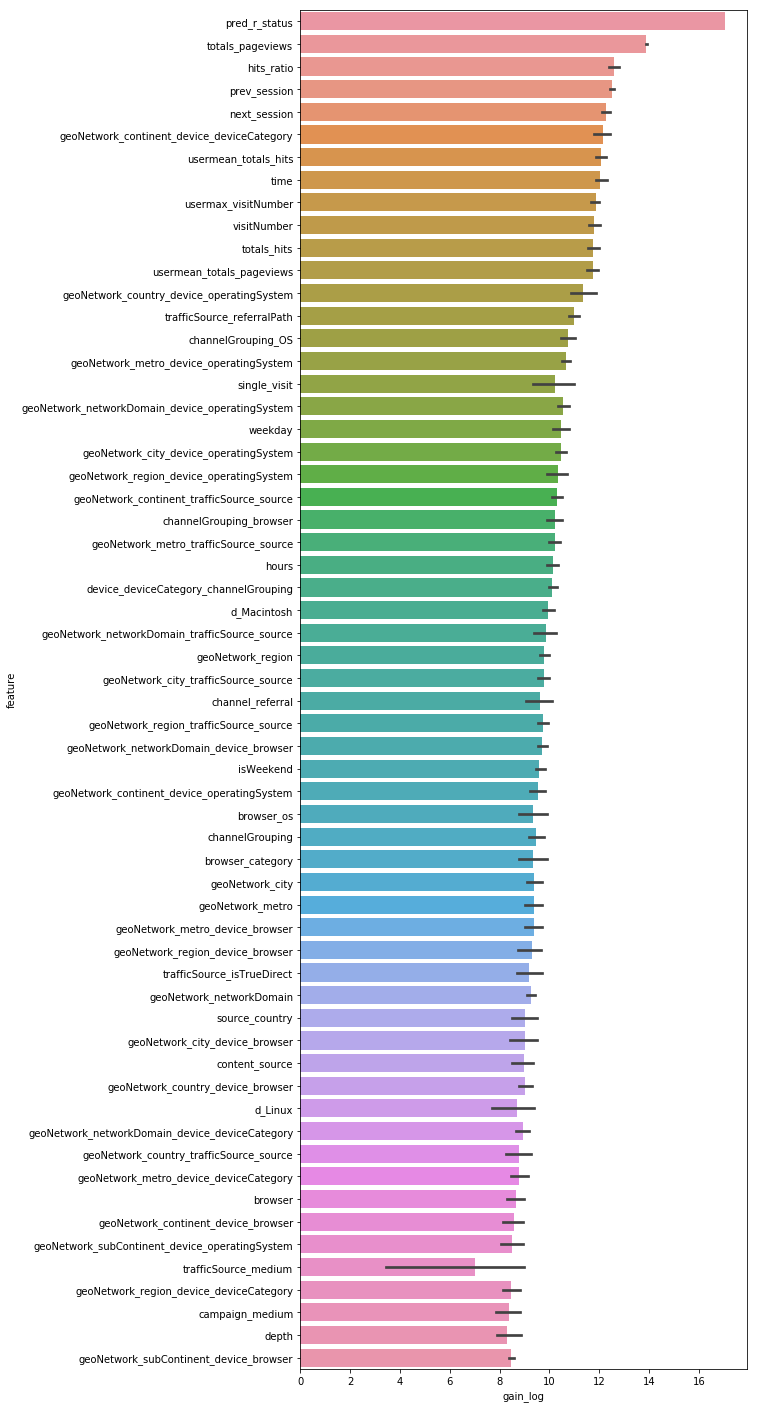

In [87]:
importances['gain_log'] = np.log1p(importances['gain'])
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 25))
sns.barplot(x='gain_log', y='feature', data=importances.sort_values('mean_gain', ascending=False).iloc[:300])

In [88]:
len(oof_reg_preds),len(train)

(1708336, 1708336)

In [89]:
len(sub_reg_preds),len(test)

(401589, 401589)

In [90]:
train['predictions'] = np.expm1(oof_reg_preds)
test['predictions'] = sub_reg_preds

In [91]:
##计算单个用户会话总数
train["sess_count"]=1;
train_sess_num = train[['fullVisitorId', 'sess_count']].groupby('fullVisitorId').sum()
test["sess_count"]=1;
test_sess_num = test[['fullVisitorId', 'sess_count']].groupby('fullVisitorId').sum()

In [92]:
###将大于20次的会话数量限制为20 （大于20次数据过少）
train_sess_num['sess_count']=train_sess_num['sess_count'].apply(lambda x: 20 if x>20 else x)
test_sess_num['sess_count']=test_sess_num['sess_count'].apply(lambda x: 20 if x>20 else x)

In [93]:
####这里采用均值合并，对于类型特征来说并不合理
train_agg = train[train_features+['pred_r_status']+['fullVisitorId']].groupby('fullVisitorId').mean()

In [94]:
train_pred = train[['fullVisitorId', 'predictions']].groupby('fullVisitorId').sum()
len(train_pred)

1328518

In [95]:
train_fulldata = pd.concat([train_agg, train_pred,train_sess_num], axis=1).astype(float)

In [96]:
test_agg = test[train_features+['pred_r_status']+['fullVisitorId']].groupby('fullVisitorId').mean()
test_pred = test[['fullVisitorId', 'predictions']].groupby('fullVisitorId').sum()
test_fulldata = pd.concat([test_agg, test_pred,test_sess_num], axis=1).astype(float)


In [98]:
test_fulldata.shape,train_fulldata.shape

((296918, 93), (1328518, 93))

In [99]:
train['target'] = y_reg
trn_user_target = train[['fullVisitorId', 'target']].groupby('fullVisitorId').sum()

In [100]:
folds = get_folds(df=train_fulldata[['totals_pageviews']].reset_index(), n_splits=5)

lgb_oof_preds = np.zeros(train_fulldata.shape[0])
lgb_sub_preds = np.zeros(test_fulldata.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train_fulldata.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = train_fulldata.iloc[val_], trn_user_target['target'].iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(trn_x, np.log1p(trn_y)), (val_x, np.log1p(val_y))],
        eval_names=['TRAIN', 'VALID'],
        early_stopping_rounds=50,
        eval_metric='rmse',
        verbose=100
    )
    
    imp_df = pd.DataFrame()
    imp_df['feature'] = trn_x.columns
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    vis_importances = pd.concat([vis_importances, imp_df], axis=0, sort=False)
    
    lgb_oof_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    lgb_oof_preds[lgb_oof_preds < 0] = 0
    
    # Make sure features are in the same order
    _preds = reg.predict(test_fulldata[train_fulldata.columns], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    lgb_sub_preds += _preds / len(folds)
    
mean_squared_error(np.log1p(trn_user_target['target']), lgb_oof_preds) ** .5

Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.47016	TRAIN's l2: 2.16136	VALID's rmse: 1.50796	VALID's l2: 2.27394
[200]	TRAIN's rmse: 1.44505	TRAIN's l2: 2.08816	VALID's rmse: 1.50595	VALID's l2: 2.26789
Early stopping, best iteration is:
[206]	TRAIN's rmse: 1.44407	TRAIN's l2: 2.08535	VALID's rmse: 1.50582	VALID's l2: 2.2675
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.47228	TRAIN's l2: 2.16762	VALID's rmse: 1.4997	VALID's l2: 2.24909
[200]	TRAIN's rmse: 1.44713	TRAIN's l2: 2.09419	VALID's rmse: 1.49784	VALID's l2: 2.24352
Early stopping, best iteration is:
[150]	TRAIN's rmse: 1.45767	TRAIN's l2: 2.12481	VALID's rmse: 1.49761	VALID's l2: 2.24285
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.46904	TRAIN's l2: 2.15807	VALID's rmse: 1.51179	VALID's l2: 2.2855
Early stopping, best iteration is:
[147]	TRAIN's rmse: 1.45511	TRAIN's l2: 2.11734	VALID's rmse: 1.5097	VALID's l2: 2

1.4988034347722374

/home/baitong/tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


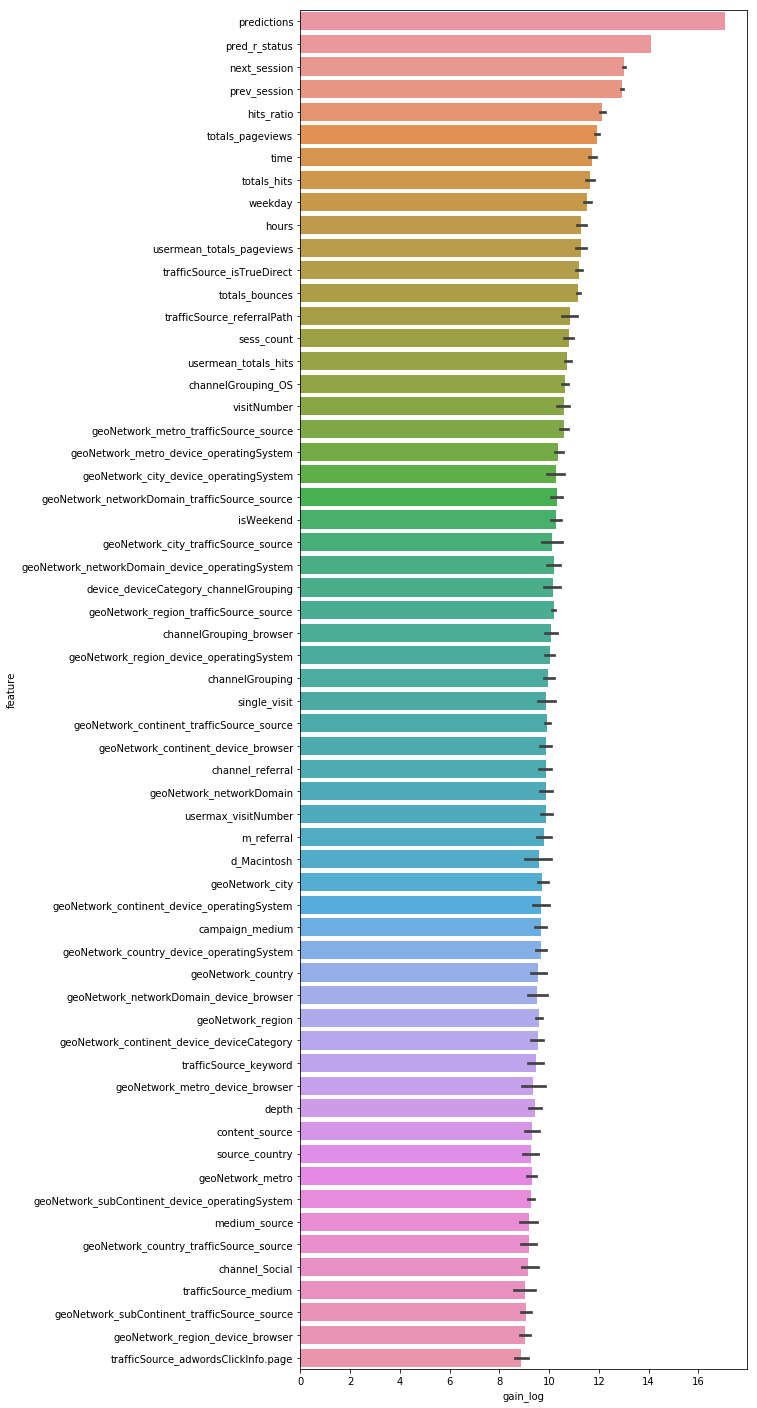

In [101]:
vis_importances['gain_log'] = np.log1p(vis_importances['gain'])
mean_gain = vis_importances[['gain', 'feature']].groupby('feature').mean()
vis_importances['mean_gain'] = vis_importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 25))
sns.barplot(x='gain_log', y='feature', data=vis_importances.sort_values('mean_gain', ascending=False).iloc[:300])

In [102]:
xgb_params = {
        'objective': 'reg:linear',
        'booster': 'gbtree',
        'learning_rate': 0.03,
        'max_depth': 22,
        'min_child_weight': 57,
        'gamma' : 1.45,
        'alpha': 0.0,
        'lambda': 0.0,
        'subsample': 0.67,
        'colsample_bytree': 0.054,
        'colsample_bylevel': 0.50,
        'n_jobs': -1,
        'random_state': 456
    }

In [104]:
from xgboost import XGBRegressor
folds = get_folds(df=train_fulldata[['totals_pageviews']].reset_index(), n_splits=5)

xgb_oof_preds = np.zeros(train_fulldata.shape[0])
xgb_sub_preds = np.zeros(test_fulldata.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train_fulldata.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = train_fulldata.iloc[val_], trn_user_target['target'].iloc[val_]
    
    xgb = XGBRegressor(**xgb_params, n_estimators=1300)
    
    xgb.fit(trn_x, np.log1p(trn_y),
            eval_set=[(val_x, np.log1p(val_y))],
            early_stopping_rounds=50,
            eval_metric='rmse',
            verbose = 100)
    xgb_oof_preds[val_] = xgb.predict(val_x)
    xgb_oof_preds[xgb_oof_preds < 0] = 0
    
    # Make sure features are in the same order
    _preds = xgb.predict(test_fulldata[train_fulldata.columns])
    _preds[_preds < 0] = 0
    xgb_sub_preds += _preds / len(folds)
    
mean_squared_error(np.log1p(trn_user_target['target']), xgb_oof_preds) ** .5

[0]	validation_0-rmse:1.95067
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:1.60319
[200]	validation_0-rmse:1.5394
[300]	validation_0-rmse:1.52124
[400]	validation_0-rmse:1.51541
[500]	validation_0-rmse:1.51377
[600]	validation_0-rmse:1.51221
Stopping. Best iteration:
[619]	validation_0-rmse:1.51189

[0]	validation_0-rmse:1.95091
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:1.5915
[200]	validation_0-rmse:1.52945
[300]	validation_0-rmse:1.51774
[400]	validation_0-rmse:1.51337
[500]	validation_0-rmse:1.50982
[600]	validation_0-rmse:1.50838
[700]	validation_0-rmse:1.5077
Stopping. Best iteration:
[684]	validation_0-rmse:1.5076

[0]	validation_0-rmse:1.94582
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:1.60704
[200]	validation_0-rmse:1.5395
[300]	validation_0-rmse:1.52314
[400]	validation_0-rmse:1.51645
[500]	validation_0-rmse:1.51582
Stopping. Best iteration:


1.5061943811307155

In [105]:
cat_param = {
    'learning_rate' :0.03,
    'depth' :10,
    'eval_metric' :'RMSE',
    'od_type' :'Iter',
    'metric_period ' : 50,
    'od_wait' : 20,
    'seed' : 42
    
}

In [106]:
from catboost import CatBoostRegressor
folds = get_folds(df=train_fulldata[['totals_pageviews']].reset_index(), n_splits=5)

cat_oof_preds = np.zeros(train_fulldata.shape[0])
cat_sub_preds = np.zeros(test_fulldata.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train_fulldata.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = train_fulldata.iloc[val_], trn_user_target['target'].iloc[val_]
    
    cat = CatBoostRegressor(iterations=1000,learning_rate=0.03,
                            depth=10,
                            eval_metric='RMSE',
                            random_seed = 42,
                            bagging_temperature = 0.2,
                            od_type='Iter',
                            metric_period = 50,
                            od_wait=20)
    cat.fit(trn_x, np.log1p(trn_y), 
            eval_set=[(val_x, np.log1p(val_y))],
            early_stopping_rounds=50,
            use_best_model=True,
            verbose=100)
    cat_oof_preds[val_] = cat.predict(val_x)
    cat_oof_preds[cat_oof_preds < 0] = 0
    
    # Make sure features are in the same order
    _preds = cat.predict(test_fulldata[train_fulldata.columns])
    _preds[_preds < 0] = 0
    cat_sub_preds += _preds / len(folds)
    
mean_squared_error(np.log1p(trn_user_target['target']), cat_oof_preds) ** .5

0:	learn: 1.9433509	test: 1.9422463	best: 1.9422463 (0)	total: 531ms	remaining: 8m 50s
100:	learn: 1.4718155	test: 1.5071362	best: 1.5071362 (100)	total: 46.6s	remaining: 6m 54s
200:	learn: 1.4398747	test: 1.5049555	best: 1.5046944 (187)	total: 1m 32s	remaining: 6m 7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.504694444
bestIteration = 187

Shrink model to first 188 iterations.


0:	learn: 1.9433188	test: 1.9422988	best: 1.9422988 (0)	total: 456ms	remaining: 7m 35s
100:	learn: 1.4734695	test: 1.4995892	best: 1.4995892 (100)	total: 49s	remaining: 7m 15s
200:	learn: 1.4377118	test: 1.4973409	best: 1.4972520 (197)	total: 1m 38s	remaining: 6m 30s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.497252035
bestIteration = 197

Shrink model to first 198 iterations.


0:	learn: 1.9445230	test: 1.9374864	best: 1.9374864 (0)	total: 500ms	remaining: 8m 19s
100:	learn: 1.4690854	test: 1.5121567	best: 1.5121567 (100)	total: 48.6s	remaining: 7m 12s
200:	learn: 1.4336776	test: 1.5103142	best: 1.5095559 (175)	total: 1m 37s	remaining: 6m 28s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.509555873
bestIteration = 175

Shrink model to first 176 iterations.


0:	learn: 1.9456363	test: 1.9331342	best: 1.9331342 (0)	total: 493ms	remaining: 8m 12s
100:	learn: 1.4782281	test: 1.4773171	best: 1.4773171 (100)	total: 49s	remaining: 7m 16s
200:	learn: 1.4439464	test: 1.4758684	best: 1.4753587 (155)	total: 1m 36s	remaining: 6m 23s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.475358719
bestIteration = 155

Shrink model to first 156 iterations.


0:	learn: 1.9387282	test: 1.9608679	best: 1.9608679 (0)	total: 506ms	remaining: 8m 25s
100:	learn: 1.4709057	test: 1.5091709	best: 1.5091709 (100)	total: 48.8s	remaining: 7m 14s
200:	learn: 1.4361827	test: 1.5062803	best: 1.5061602 (190)	total: 1m 36s	remaining: 6m 23s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.506160152
bestIteration = 190

Shrink model to first 191 iterations.


1.4986506112312687

In [110]:
test_fulldata['lgb_pred'] = lgb_sub_preds
test_fulldata['xgb_pred'] = xgb_sub_preds
test_fulldata['cst_pred'] = cat_sub_preds
test_final_data = test_fulldata[['lgb_pred','xgb_pred','cst_pred']]

In [111]:
train_fulldata['lgb_pred'] = lgb_oof_preds
train_fulldata['xgb_pred'] = xgb_oof_preds
train_fulldata['cst_pred'] = cat_oof_preds
train_final_data = train_fulldata[['lgb_pred','xgb_pred','cst_pred']]

In [112]:
from sklearn.linear_model import LinearRegression

folds = get_folds(df=train_fulldata[['totals_pageviews']].reset_index(), n_splits=5)

final_oof_preds = np.zeros(train_final_data.shape[0])
final_sub_preds = np.zeros(test_final_data.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train_final_data.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = train_final_data.iloc[val_], trn_user_target['target'].iloc[val_]
    
    lin_reg = LinearRegression()
    lin_reg.fit(trn_x,np.log1p(trn_y))
    final_oof_preds[val_] = lin_reg.predict(val_x)
    final_oof_preds[final_oof_preds < 0] = 0
    
    # Make sure features are in the same order
    _preds = lin_reg.predict(test_final_data[train_final_data.columns])
    _preds[_preds < 0] = 0
    final_sub_preds += _preds / len(folds)
    
mean_squared_error(np.log1p(trn_user_target['target']), final_oof_preds) ** .5

1.4958786450099195

In [114]:
test_fulldata['PredictedLogRevenue'] = final_sub_preds
test_fulldata[['PredictedLogRevenue']].to_csv('/home/baitong/pywork/RevenuePrediction/submission.csv', index=True)

In [115]:
len(test_fulldata)

296918